# Regression problem 

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
  
# fetch dataset automobile
automobile = fetch_ucirepo(id=10) 
# data (as pandas dataframes) 
features = automobile.data.features 
targets = automobile.data.targets 

df = pd.concat([features, targets], axis=1) # Unisco X e y in un unico DataFrame per fare pulizia
df = df.dropna().drop_duplicates() # remove rows with NaN or dupl
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df.to_csv("automobile.csv", index=False)

# Conversion to num
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df = pd.get_dummies(df, drop_first=True) # one-hot encoding
# i.e.: 1 if "gas", 0 if "diesel"
df = df.astype(float) 

# After cleaning rejoin X and y
X = df.drop("price", axis=1)
y = df["price"]

X = X.values
y = pd.to_numeric(y)

X.shape, y.shape

((159, 51), (159,))

## Multivariate linear regression from scratch

In [3]:
class MultivariateRegression:
    def __init__(self, alpha, n_iterations):
        self.alpha = alpha
        self.n_iterations = n_iterations
        self.theta = None
        self.X_mean = None
        self.X_std = None

    def _normalize(self, X, training=True):
        if training:
            self.X_mean = np.mean(X, axis=0)
            self.X_std = np.std(X, axis=0)

            self.X_std = np.where(self.X_std == 0, 1.0, self.X_std) # std=1 if it was 0 to avoid error division
        elif self.X_mean is None or self.X_std is None:
            raise ValueError("Normalization failed.")
        return (X - self.X_mean) / self.X_std


    def fit(self, X, y): # y = target
        X = self._normalize(X, training=True)
        X = np.c_[np.ones(X.shape[0]), X] # column of 1s for bias
        theta = np.zeros(X.shape[1])  # 1 par for each feature + bias
        m = len(y) 
        self.loss_history = []
        # params early stopping
        patience = 30
        best_loss = float('inf')
        patience_counter = patience

        for i in range(self.n_iterations):
            y_pred = X @ theta
            loss = (1/(2*m)) * np.sum((y_pred - y) ** 2)
            self.loss_history.append(loss)
            if loss < best_loss:
                best_loss = loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter == 0:
                    print(f"Early stopping at iteration {i}")
                    break
            gradient = (1/m) * X.T @ (y_pred - y) # gradient of the cost function
            #theta is the weight i am assigning to each feature
            theta = theta - self.alpha * gradient # params updating
        
        # print(f"Final loss: {loss:.4f}")
        self.theta = theta

    def predict(self, X):
        X = self._normalize(X, training=False)
        X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.theta # calculate predictions using the learned parameters

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

multivariate_regression = MultivariateRegression(alpha=0.01, n_iterations=70000)
multivariate_regression.fit(X_train, y_train)
predictions = multivariate_regression.predict(X_test)
# print("\n\n"+str(np.isnan(predictions).sum()))

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Implementation from scratch")
print(f"MSE: {mse:.4f}") # better if lower
print(f"R2: {r2:.4f}") # should be almost 1, or 1

Implementation from scratch
MSE: 3365779.9174
R2: 0.8109


In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Implementation with sklearn")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}\n")

Implementation with sklearn
MSE: 3264764.0958
R2: 0.8165



With both from scratch and scikit-learn implementation I get a very high MSE. But I am using as target the car price which can range from 5118 to 45400 (reading from the description on UCI). So it is normal because I am using very high values. The root of the MSE is the value that the model predicts wrong so a value of about $1900 on prices on that specified scale (max was 45000) is acceptable.

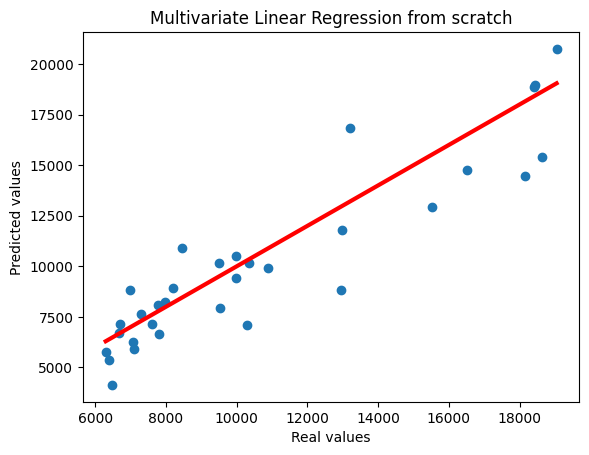

In [6]:
# Plot with regression line

import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Multivariate Linear Regression from scratch")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3)
plt.show()

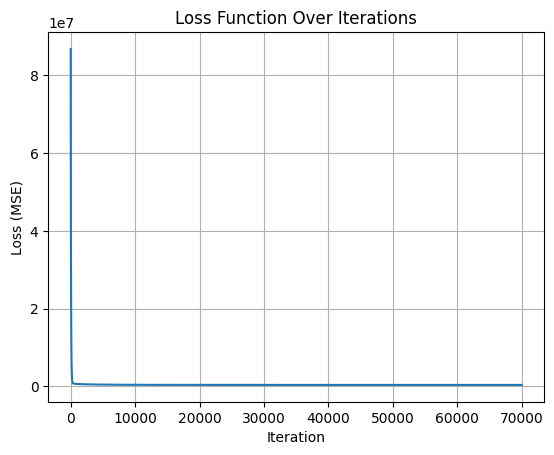

In [7]:
# Plot della funzione di costo

plt.plot(multivariate_regression.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss Function Over Iterations")
plt.grid(True)
plt.show() 

The cost function drops as expected. After some experimentation, I decided to stop the number of epochs at 70000: thereafter it falls very slowly until it stabilizes.